<a href="https://colab.research.google.com/github/pchapr/colab_learning/blob/main/MultiVariateAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Using data/finanacial_data.csv would like to build a deep learning model to identify anomolies

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
financial_data_df = pd.read_csv('data/financial_data.csv')

In [4]:
# Display the first few rows of the DataFrame to understand its structure
#print(financial_data_df.head())

# Get basic information about the DataFrame (column types, non-null values)
#print(financial_data_df.info())

# Get descriptive statistics of the numerical columns
#print(financial_data_df.describe())
financial_data_df.iloc[0]
financial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
financial_data_df['nameDest'].unique().size

2722362

In [6]:
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']
origin_dest_features = ['nameOrig', 'nameDest']

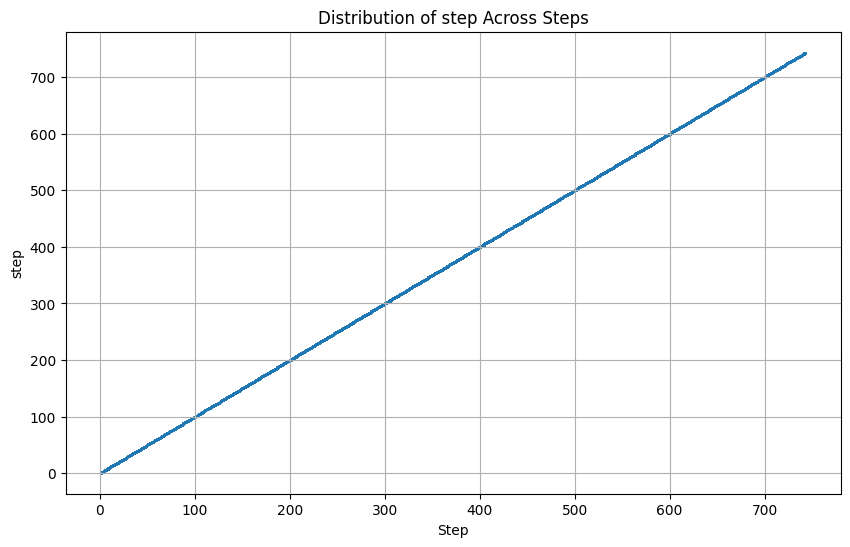

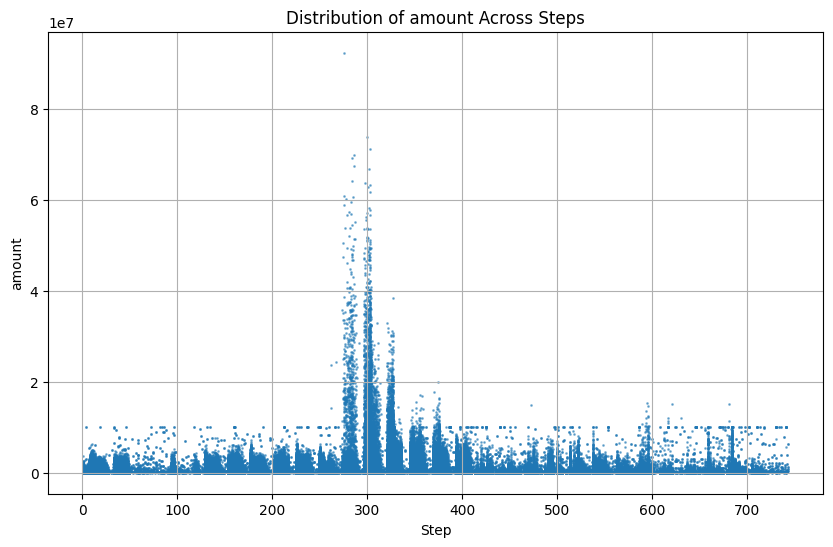

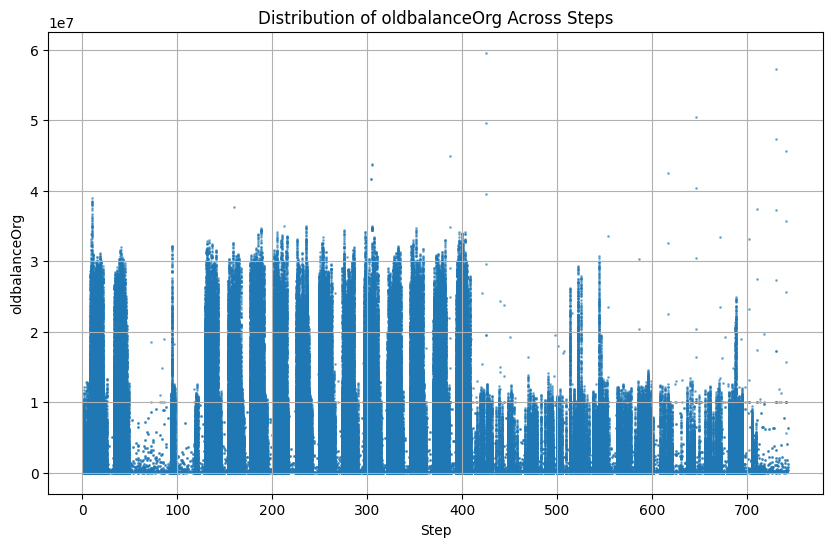

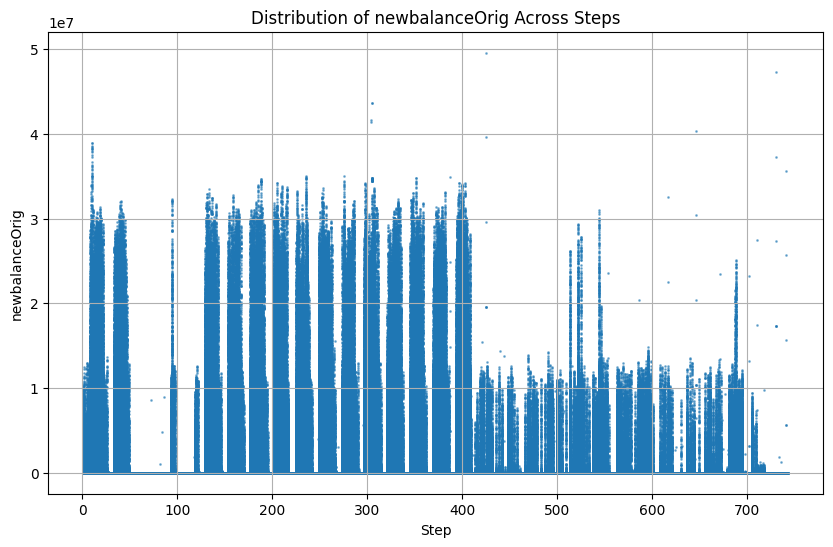

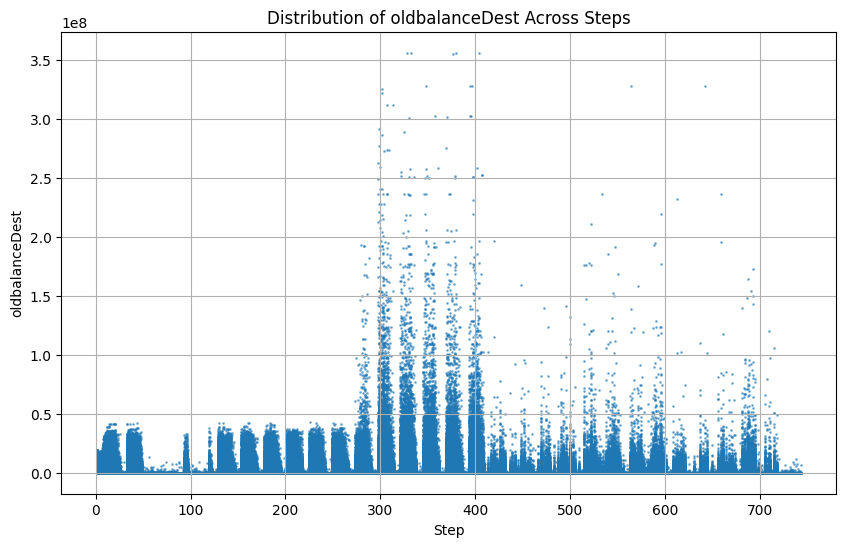

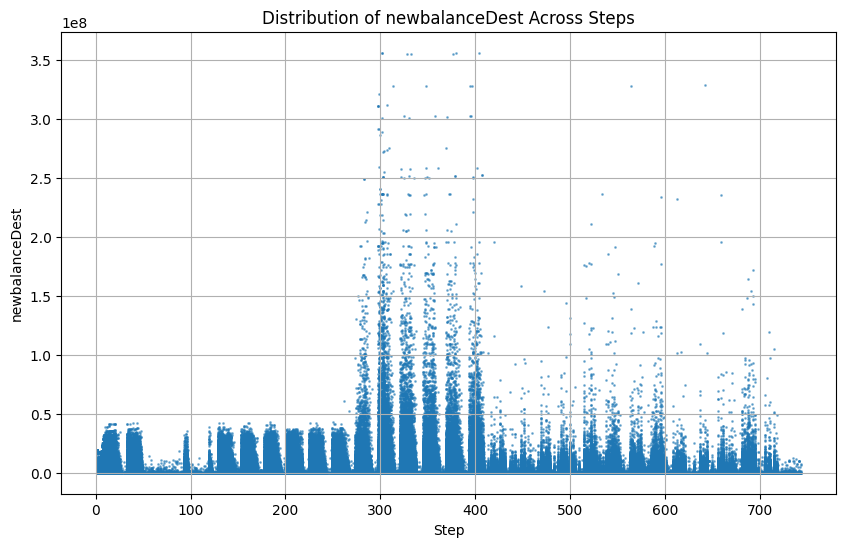

In [7]:
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(financial_data_df['step'], financial_data_df[feature], alpha=0.5, s=1)
    plt.title(f'Distribution of {feature} Across Steps')
    plt.xlabel('Step')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

In [8]:
# Scale numerical features
scaler = StandardScaler()
financial_data_df[numerical_features] = scaler.fit_transform(financial_data_df[numerical_features])

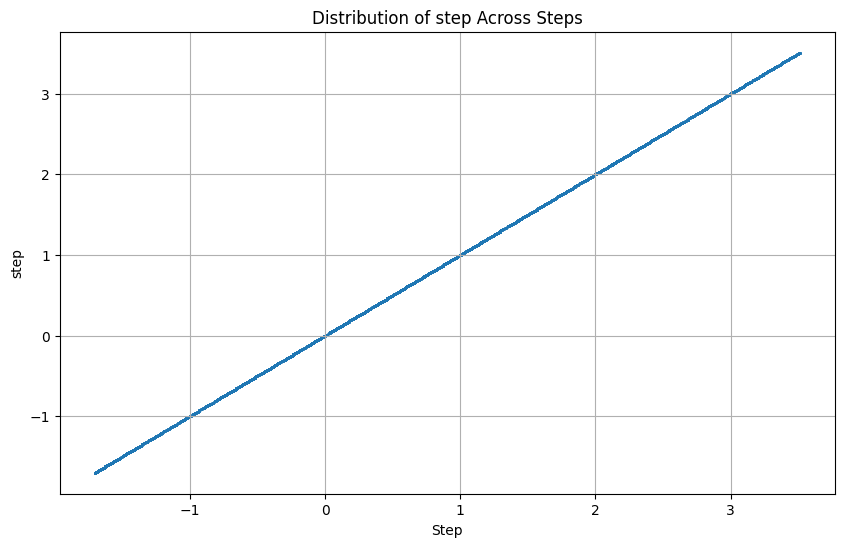

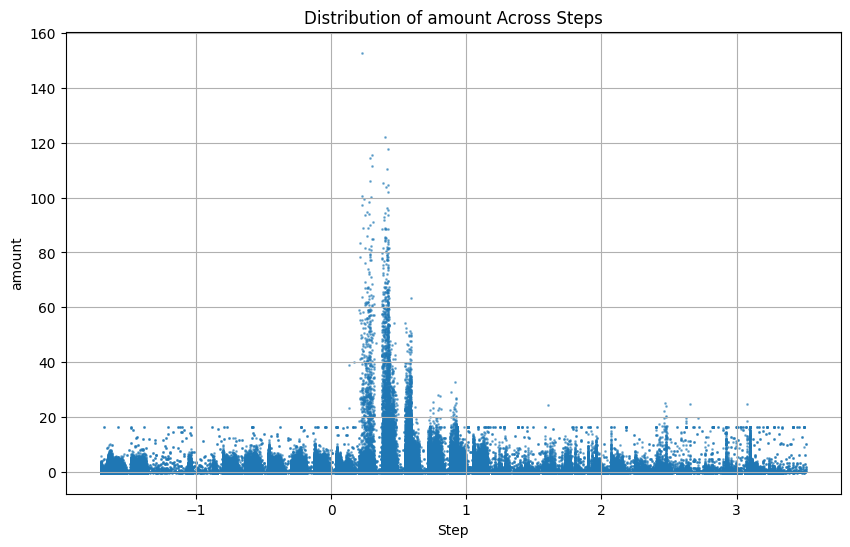

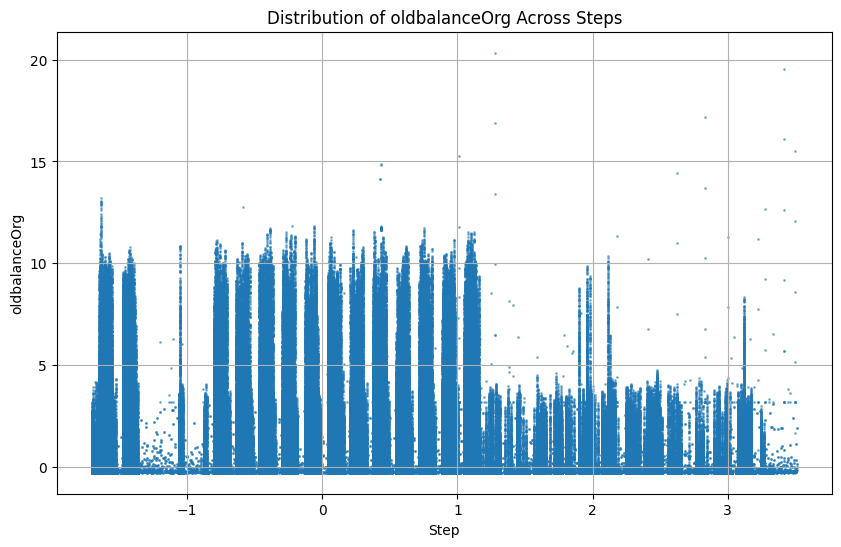

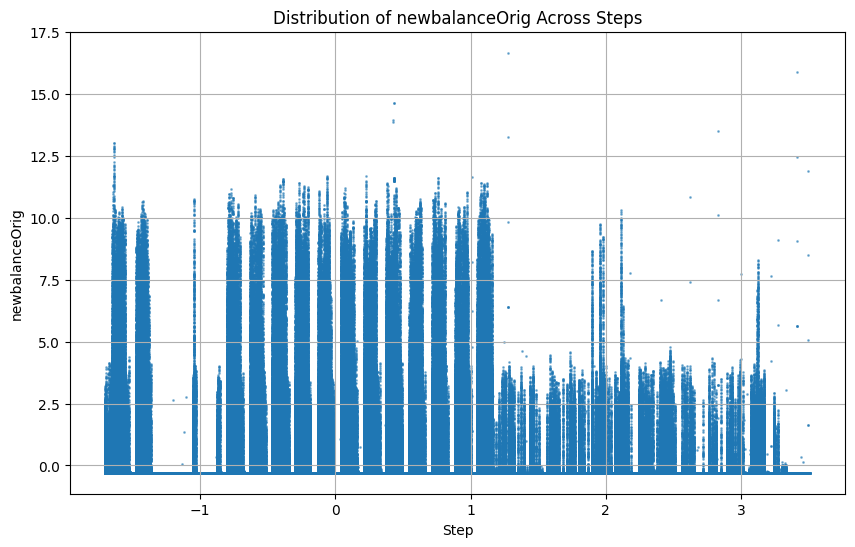

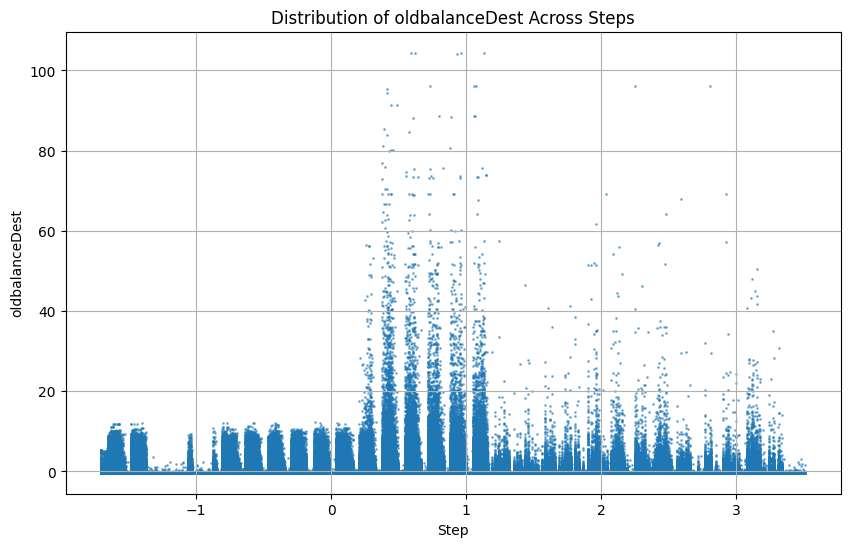

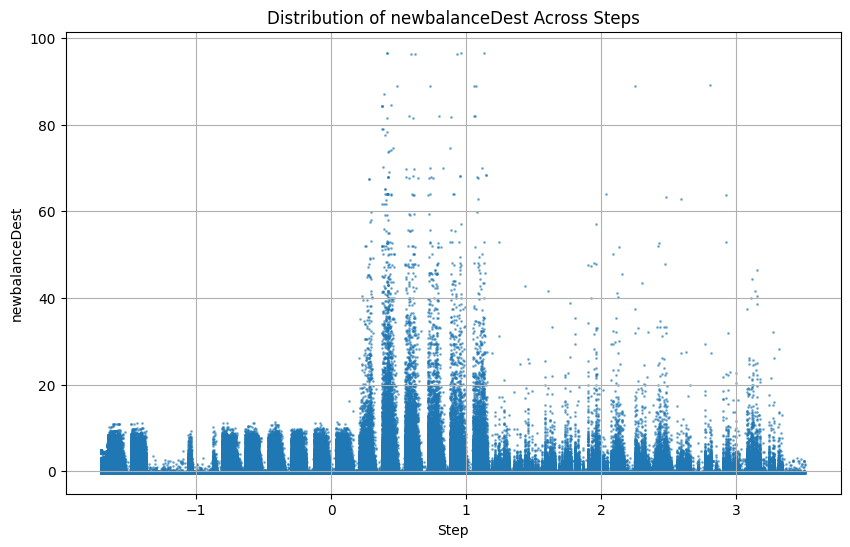

In [9]:
# prompt: Plot the numeric fields distribution across steps

# Plot distribution of numerical features across steps
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(financial_data_df['step'], financial_data_df[feature], alpha=0.5, s=1)
    plt.title(f'Distribution of {feature} Across Steps')
    plt.xlabel('Step')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


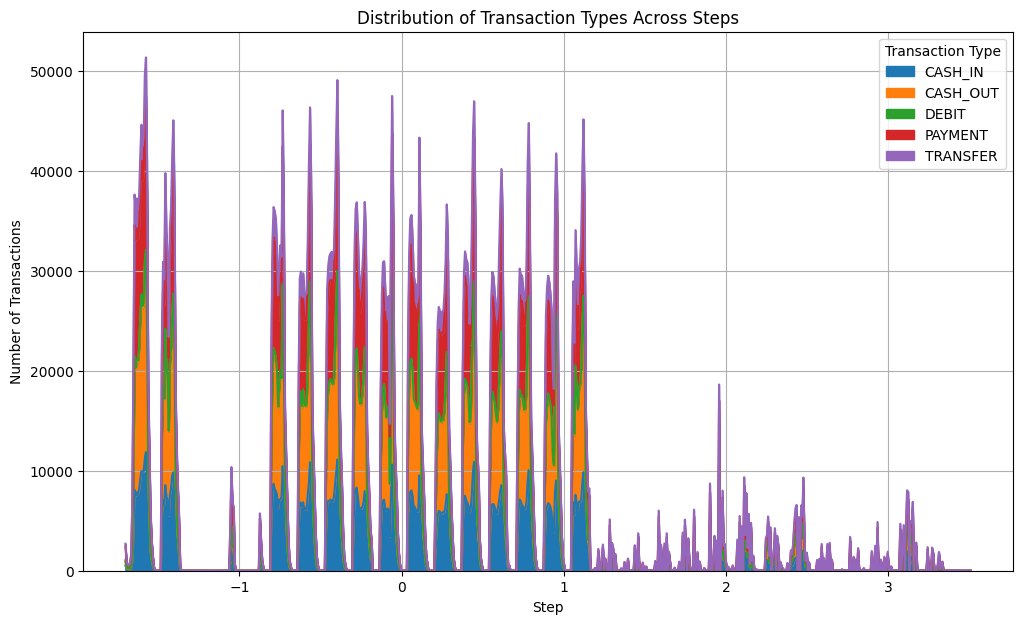

In [10]:
# prompt: Chart the type distribuction across steps as area

# Plot distribution of categorical features across steps
plt.figure(figsize=(12, 7))
financial_data_df.groupby('step')['type'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Distribution of Transaction Types Across Steps')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid(True)
plt.show()

In [11]:
# One-hot encode 'type'
encoder = OneHotEncoder(sparse_output=False)
type_encoded = encoder.fit_transform(financial_data_df[['type']])
type_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))
financial_data_df = pd.concat([financial_data_df.drop('type', axis=1).reset_index(drop=True), type_df], axis=1)

In [12]:
financial_data_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.703042,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
1,-1.703042,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
2,-1.703042,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,0.0,0.0,0.0,0.0,1.0
3,-1.703042,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,0.0,1.0,0.0,0.0,0.0
4,-1.703042,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0


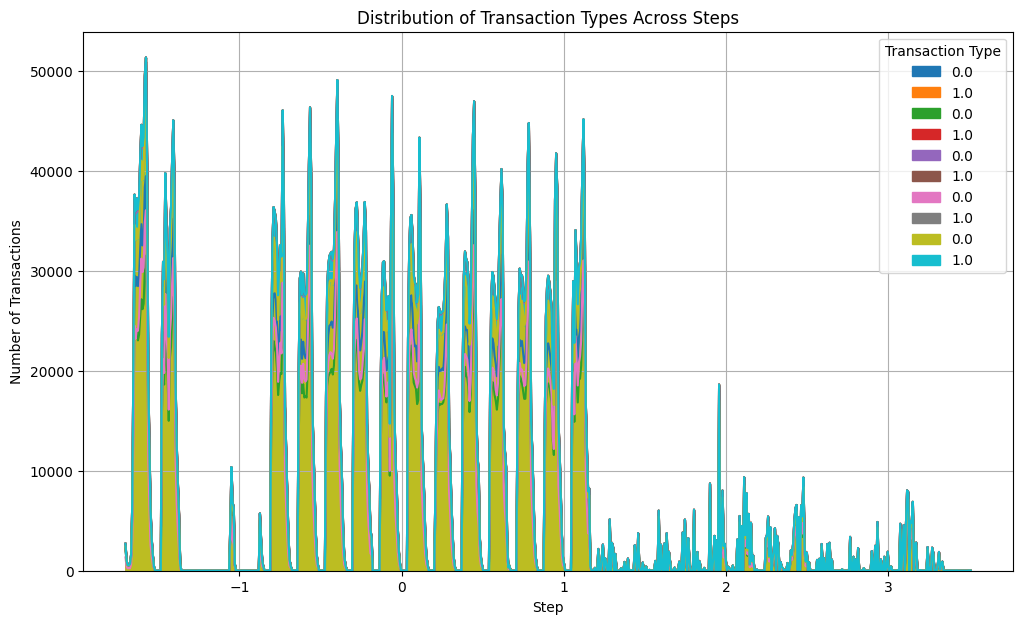

In [13]:
# prompt: Chart the type distribuction across steps as area

# Plot distribution of categorical features across steps
plt.figure(figsize=(12, 7))
financial_data_df.groupby('step')['type_CASH_IN'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_CASH_OUT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_DEBIT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_PAYMENT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_TRANSFER'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Distribution of Transaction Types Across Steps')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid(True)
plt.show()

In [14]:
# Tokenizing the text field for deeplearning model training
max_origin_features = financial_data_df['nameOrig'].nunique()
origin_tokenizer = Tokenizer(num_words=max_origin_features)
origin_tokenizer.fit_on_texts(financial_data_df['nameOrig'])
origin_sequences = origin_tokenizer.texts_to_sequences(financial_data_df['nameOrig'])
padded_origin = pad_sequences(origin_sequences, maxlen=1) # Still treat as sequence of length 1 at each step

In [15]:
financial_data_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.703042,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
1,-1.703042,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
2,-1.703042,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,0.0,0.0,0.0,0.0,1.0
3,-1.703042,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,0.0,1.0,0.0,0.0,0.0
4,-1.703042,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0


In [16]:
max_dest_features = financial_data_df['nameDest'].nunique()
dest_tokenizer = Tokenizer(num_words=max_dest_features)
dest_tokenizer.fit_on_texts(financial_data_df['nameDest'])
dest_sequences = dest_tokenizer.texts_to_sequences(financial_data_df['nameDest'])
padded_dest = pad_sequences(dest_sequences, maxlen=1) # Still treat as sequence of length 1 at each step

In [17]:
# Combine features for sequence generation
feature_columns = numerical_features + list(type_df.columns)
X = financial_data_df[feature_columns].values
origin_ids = padded_origin.reshape(-1, 1)
dest_ids = padded_dest.reshape(-1, 1)
y_fraud = financial_data_df['isFraud'].values

# 3. Sequence Generation
sequence_length = 20 # Choose an appropriate sequence length
batch_size = 128

In [18]:
# Combine features for sequence generation (now including tokenized IDs)
def create_sequences_with_ids(data_numerical_encoded, data_type_encoded, origin_ids, dest_ids, y, sequence_length):
    # ... (Logic to create sequences where each step includes numerical, type, origin_id, dest_id) ...
    sequences = []
    targets = []
    y_seqs = []
    for i in range(len(data_numerical_encoded) - sequence_length):
        numerical_seq = data_numerical_encoded[i:i + sequence_length]
        type_seq = data_type_encoded[i:i + sequence_length]
        origin_seq = origin_ids[i:i + sequence_length]
        dest_seq = dest_ids[i:i + sequence_length]
        combined_seq = np.concatenate([numerical_seq, type_seq, origin_seq, dest_seq], axis=1) # Combine features
        target = data_numerical_encoded[i + sequence_length]
        y_val = y[i:i + sequence_length]
        sequences.append(combined_seq)
        targets.append(target)
        y_seqs.append(y_val)
    return np.array(sequences), np.array(targets), np.array(y_seqs)

In [19]:
numerical_encoded = scaler.transform(financial_data_df[numerical_features]) # Ensure scaling is done before sequence creation



In [ ]:

X_seq, y_next, y_fraud_seq = create_sequences_with_ids(
    numerical_encoded, type_encoded, padded_origin, padded_dest, y_fraud, sequence_length
)

In [ ]:
# Split data into training and testing sets
X_train, X_test, origin_train, origin_test, dest_train, dest_test, y_train_fraud_seq, y_test_fraud_seq = train_test_split(
    X_seq, origin_sequences, dest_sequences, y_fraud_seq, test_size=0.2, random_state=42, shuffle=False
)

In [ ]:
embedding_dim=50
n_numerical_features = len(numerical_features)
n_type_features = type_encoded.shape[1]

input_numerical = Input(shape=(sequence_length, n_numerical_features), name='numerical_input')
input_type = Input(shape=(sequence_length, n_type_features), name='type_input')
input_origin = Input(shape=(sequence_length, 1), name='origin_input')
input_dest = Input(shape=(sequence_length, 1), name='dest_input')

embedding_origin = Embedding(input_dim=max_origin_features, output_dim=embedding_dim, input_length=sequence_length)(input_origin)
embedding_dest = Embedding(input_dim=max_dest_features, output_dim=embedding_dim, input_length=sequence_length)(input_dest)

merged_input = concatenate([input_numerical, input_type, embedding_origin, embedding_dest])




In [ ]:
# Encoder
lstm_enc_1 = LSTM(128, activation='relu', return_sequences=True)(merged_input)
lstm_enc_2 = LSTM(64, activation='relu', return_sequences=False)(lstm_enc_1)
repeat_vector = RepeatVector(sequence_length)(lstm_enc_2)

# Decoder
lstm_dec_1 = LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
lstm_dec_2 = LSTM(128, activation='relu', return_sequences=True)(lstm_dec_1)
output_numerical = TimeDistributed(Dense(n_numerical_features))(lstm_dec_2)
output_type = TimeDistributed(Dense(n_type_features, activation='sigmoid'))(lstm_dec_2) # Assuming one-hot encoded

autoencoder = Model(inputs=[input_numerical, input_type, input_origin, input_dest], outputs=[output_numerical, output_type])
autoencoder.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy']) # Adjust loss if needed

print(autoencoder.summary())